<a href="https://colab.research.google.com/github/pakdaniel/DataMiningFinal/blob/main/DataMiningFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install pysofaconventions
!pip3 install colorama

     |████████████████████████████████| 89 kB 3.8 MB/s 


In [183]:
# import tensorflow as tf
import numpy as np 
import random
import matplotlib.pyplot as plt
import os 
import sys
import librosa
import librosa.display
from warnings import warn
from IPython.display import Audio, display
from scipy import signal 
from scipy.io import wavfile
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torchaudio
from torchaudio import transforms

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [6]:
from google.colab import drive
drive_root = '/content/drive'
drive.mount(drive_root)

VIVAE_PATH = os.path.join(drive_root, "My Drive", "VIVAE", "full_set")
audio_paths = [os.path.join(VIVAE_PATH, hrir_path) for hrir_path in os.listdir(VIVAE_PATH)]

Mounted at /content/drive


# Previous Audio Class Using numpy and librosa

In [10]:
class Audio():
  def __init__(self, audio, sr, file_name):
    self.audio = audio
    self.N = len(audio)
    self.sr = sr 
    self.file_name = file_name
    self.labels()

  def labels(self):
    metadata = self.file_name.split("/")[-1].split("_")
    self.subject = metadata[0]
    self.emotion_label = metadata[1] 
    self.emotion_intensity = metadata[2]
    self.emotion = metadata[1] + "_" + metadata[2]

  def plot_time_series(self):
    t = np.arange(self.N)/self.sr
    plt.figure(figsize=(8,6))
    plt.plot(t, self.audio)
    plt.xlabel("Time (s)", fontsize=12)
    plt.title("Time Series", fontsize=12)
    plt.show()

  def spectrogram(self, hop_length=64, n_fft=1024):
    spec = np.abs(librosa.stft(self.audio, hop_length=hop_length, n_fft = n_fft))
    spec = librosa.amplitude_to_db(spec, ref=np.max) 
    return spec

  def plot_spectrogram(self, hop_length=64, n_fft=1024):
    spec = self.spectrogram(hop_length, n_fft)
    plt.figure(figsize=(8,6));
    librosa.display.specshow(spec, sr=self.sr, hop_length=hop_length, x_axis='time', y_axis='linear');
    plt.colorbar(format='%+2.0f dB');
    plt.title('Spectrogram', fontsize=12);

  def mel_spectrogram(self, hop_length=64, n_fft=1024, n_mels=64):
    mel_spec = librosa.feature.melspectrogram(self.audio, sr=self.sr, hop_length=hop_length, n_fft=n_fft, n_mels=n_mels)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec

  def plot_mel_spectrogram(self, hop_length=64, n_fft=1024, n_mels=64):
    spec = self.mel_spectrogram(hop_length, n_fft, n_mels)
    plt.figure(figsize=(8,6))
    librosa.display.specshow(spec, sr=self.sr, hop_length=hop_length, x_axis='time', y_axis='mel');
    plt.colorbar(format='%+2.0f dB');
    plt.title('Mel Spectrogram', fontsize=12);

# plt.figure(figsize=(8,6))
# plt.title('Spectrogram')    
# Pxx, freqs, bins, im = plt.specgram(y,Fs=fs,NFFT=256)

# print(Pxx.shape)
# print(freqs.shape)
# print(bins.shape)

# plt.xlabel('Time')
# plt.ylabel('Frequency')

In [11]:
audio_all = []
i = 0
for audio_path in audio_paths:
  i = i+1
  data, sr = librosa.load(audio_path, sr=None) # by default it scales data between [-1, 1]
  # sr, data = wavfile.read(audio_path)
  audio_all.append(Audio(data, sr, audio_path))
  if i % 100 == 0:
    print(f"At {i}")

At 100
At 200
At 300
At 400
At 500
At 600
At 700
At 800
At 900
At 1000


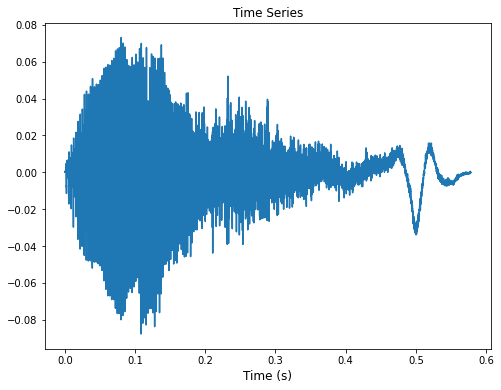

In [15]:
audio_all[0].plot_time_series()

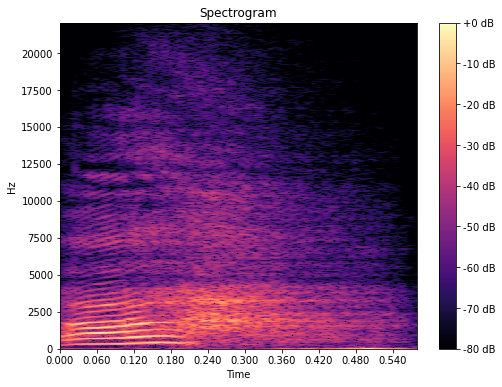

In [101]:
audio_all[0].plot_spectrogram()

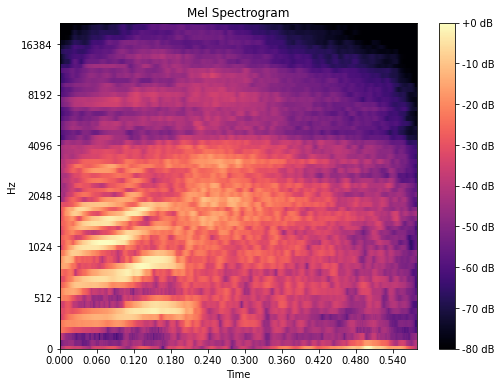

In [102]:
audio_all[0].plot_mel_spectrogram()

In [103]:
audio_all[0].mel_spectrogram().shape

(64, 399)

# Distribution of Labels

In [174]:
emotion_type = []
emotion_intensities = []
emotion_labels = []

for file_name in audio_paths:
  metadata = file_name.split("/")[-1].split("_")
  emotion_type.append(metadata[1]) 
  emotion_intensities.append(metadata[2])
  emotion_labels.append(metadata[1] + "_" + metadata[2])

In [175]:
# res = dict()
# for i in emotion_type:
#   if i not in res:
#     res[i] = 1
#   else:
#     res[i] += 1

# res = dict(sorted(res.items()))

# label_encoding = {}
# for count, val in enumerate(res):
#   label_encoding[val] = count

# label_encoding

In [176]:
# res = dict()
# for i in emotion_intensities:
#   if i not in res:
#     res[i] = 1
#   else:
#     res[i] += 1

# res = dict(sorted(res.items()))

# label_encoding = {}
# for count, val in enumerate(res):
#   label_encoding[val] = count

# label_encoding

In [177]:
res = dict()
for i in emotion_labels:
  if i not in res:
    res[i] = 1
  else:
    res[i] += 1

res = dict(sorted(res.items()))

label_encoding = {}
for count, val in enumerate(res):
  label_encoding[val] = count

label_encoding

{'achievement_low': 0,
 'achievement_moderate': 1,
 'achievement_peak': 2,
 'achievement_strong': 3,
 'anger_low': 4,
 'anger_moderate': 5,
 'anger_peak': 6,
 'anger_strong': 7,
 'fear_low': 8,
 'fear_moderate': 9,
 'fear_peak': 10,
 'fear_strong': 11,
 'pain_low': 12,
 'pain_moderate': 13,
 'pain_peak': 14,
 'pain_strong': 15,
 'pleasure_low': 16,
 'pleasure_moderate': 17,
 'pleasure_peak': 18,
 'pleasure_strong': 19,
 'surprise_low': 20,
 'surprise_moderate': 21,
 'surprise_peak': 22,
 'surprise_strong': 23}

# Creating Audio Class Using torchaudio 

In [191]:
class Audio():
  def __init__(self, audio_file, label_type, label_mapping):
    self.audio_file = audio_file
    self.open()
    self.set_labels(label_type, label_mapping)

  def open(self):
    self.audio, self.sr = torchaudio.load(self.audio_file)

  def set_labels(self, label_type, label_mapping):
    metadata = self.audio_file.split("/")[-1].split("_")
    self.subject = metadata[0]
    if label_type == "emotion_type":
      self.label = metadata[1]
    elif label_type == "emotion_intensity":
      self.label = metadata[2]
    elif label_type == "emotion_full_label":
      self.label = metadata[1] + "_" + metadata[2]
    self.label_encoding = label_mapping[self.label]

  def plot_time_series(self):
    t = np.arange(self.audio.size()[1])/self.sr
    plt.figure(figsize=(8,6))
    plt.plot(t, self.audio.squeeze().detach().numpy())
    plt.xlabel("Time (s)", fontsize=12)
    plt.title("Time Series", fontsize=12)
    plt.show()

  def mel_spectrogram(self, hop_length=64, n_fft=1024, n_mels=64, top_db=80):
    spec = transforms.MelSpectrogram(self.sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)(self.audio)
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return spec

  def plot_mel_spectrogram(self, hop_length=64, n_fft=1024, n_mels=64, top_db=80):
    spec = self.mel_spectrogram(hop_length=hop_length, n_fft=n_fft, n_mels=n_mels, top_db=top_db).detach().squeeze().numpy()
    plt.figure(figsize=(8,6))
    librosa.display.specshow(spec, sr=self.sr, hop_length=hop_length, x_axis='time', y_axis='mel');
    plt.colorbar(format='%+2.0f dB');
    plt.title('Mel Spectrogram', fontsize=12);
  
  def get_spectrogram_and_label(self):
    return self.mel_spectrogram(), self.label_encoding

  def get_time_series_and_label(self):
    return self.audio, self.label_encoding

In [192]:
audio_test = Audio(audio_paths[0], "emotion_full_label", label_encoding)

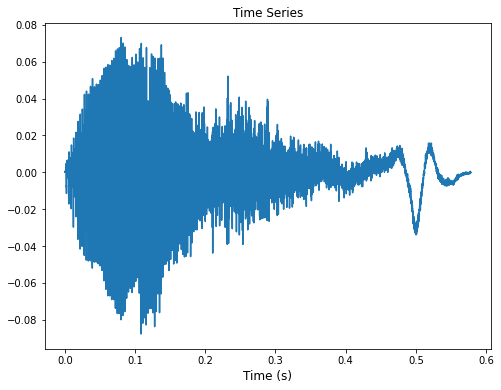

In [193]:
audio_test.plot_time_series()

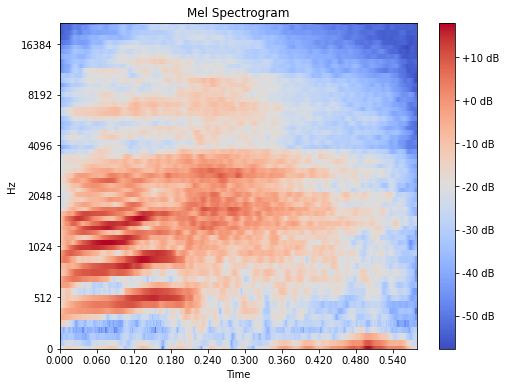

In [194]:
audio_test.plot_mel_spectrogram()

# Creating Dataset

In [182]:
class AudioDataset(Dataset):
  def __init__(self, audio_paths, label_type, label_mapping):
    super(AudioDataset, self).__init__()
    self.audio_paths = audio_paths
    self.label_type = label_type 
    self.label_mapping = label_mapping

  def __len__(self):
    return len(self.audio_paths)

  def __getitem__(self, idx):
      audio = Audio(self.audio_paths[idx], self.label_type, self.label_mapping)
      return audio.get_spectrogram_and_label()

In [167]:
dataset = AudioDataset(audio_paths, "emotion_full_label", label_encoding)
loader = DataLoader(dataset, shuffle=1, batch_size=10)

In [173]:
audio_paths[1084]

'/content/drive/My Drive/VIVAE/full_set/S11_achievement_peak_02.wav'

In [172]:
dataset[1084]

(tensor([[[-19.0018, -19.4646, -20.8227,  ..., -37.8493, -42.1530, -44.4361],
          [-21.1204, -21.3838, -22.2529,  ..., -40.4562, -41.0151, -41.2655],
          [-22.6416, -23.0167, -24.1024,  ..., -44.4361, -44.4361, -44.4361],
          ...,
          [-28.3062, -28.2967, -28.2717,  ..., -40.6629, -40.8340, -40.8857],
          [-30.8131, -30.9505, -31.3286,  ..., -39.6029, -39.3095, -39.1993],
          [-35.8339, -35.9311, -36.1251,  ..., -38.5641, -38.4999, -38.4713]]]),
 2)

# Creating Model

In [ ]:
class Model1(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Model1, self).__init__()
        self.fc1 = nn.Linear(input_dim, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training


In [184]:
dataset = AudioDataset(audio_paths, "emotion_full_label", label_encoding)
dataset_size = len(dataset)

split = 0.2
test_size = int(np.floor(split * dataset_size))
train_size = dataset_size - test_size
train_set, test_set = random_split(dataset, [train_size, test_size])

batch_size = 20
train_loader = DataLoader(train_set, 
                          shuffle = True, 
                          batch_size = batch_size)
test_loader = DataLoader(test_set, 
                        shuffle = True, 
                        batch_size = batch_size)